In [1]:
import os
import torch
from torch import nn, einsum
import torch.optim as optim
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
from datetime import datetime

from loading import *
import netCDF4
import h5netcdf
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import Sampler

#Modules
from einops import rearrange
from einops.layers.torch import Rearrange

from sklearn.metrics import mean_squared_error

import holoviews as hv
import hvplot.pandas
import hvplot.xarray
hv.extension('bokeh')

import gc
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()


# Data

In [2]:
radar_xarray = load_radar()
radar_xarray = radar_xarray.rename({"var0_1_201_surface":"radar"})
coords = load_coords()
rain = load_gauges_values()
rain = rain[rain.index.month < 4]

#shift hours
radar_xarray["time"] = radar_xarray["time"] + np.timedelta64(10,"h")
radar_xarray = radar_xarray.sel(time=slice( None, rain.index[-1]))
radar_xarray = radar_xarray.isel(lat=slice(0,-4)) #Drop the last 4 lattitude to have a 200*160 pixel image

coords = coords.drop(coords[coords["lat"]>radar_xarray.lat[-1].values].index) #remove jauge not in the image

#Same timestamp for rain and radar
rain = rain[rain.index >= radar_xarray["time"][0].values]
rain = rain.resample("H").bfill()
rain.columns = pd.RangeIndex(start=0, stop=len(rain.columns), step=1, name='location')

rain = rain[coords.index]

#REMOVE NA and 0 values

# Keeping gauge with few NA values
rain = rain[rain.columns[(rain.isna().sum() < rain.shape[0]*0.1)]]

#Remove gauge with a unique value of 0.0 (removes 96 gauge!!!!!)
zero_index = []
for col in rain.columns:
    if (len(rain[col].unique()) <= 1):
        zero_index += [col]
rain = rain.drop(zero_index, axis=1)

# Filling NA
rain = rain.fillna(method="bfill")
rain = rain[:-1]

# Selection of radar and coord colums
coords = coords.loc[rain.columns]

#Drop attribute of dataset
radar_xarray.lat.attrs.clear()
radar_xarray.lon.attrs.clear()

radar_points = read_radar_from_coords(radar_xarray, coords)

#Group by hour and location
radar_point_grouped = radar_points.coarsen(time=6, boundary="trim").construct(time=("dim_h", "dim_m"))
radar_point_grouped.coords["hour"] = rain.index.values
radar_point_grouped.coords["min"] = [0,1,2,3,4,5]

radar_point_grouped["radar"] = radar_point_grouped["radar"].swap_dims(
    {"dim_h": "hour", "dim_m": "min"})
radar_point_grouped=radar_point_grouped.drop("time")
radar_point_grouped["radar"] = radar_point_grouped["radar"].transpose("location", "hour","min" )
radar_point_grouped = radar_point_grouped.assign(jauge=(("location", "hour"), rain.values.T))

#Group by hour
radar_grouped = radar_xarray.coarsen(time=6, boundary="trim").construct(time=("dim_h", "dim_m"))
radar_grouped.coords["hour"] = rain.index.values
radar_grouped.coords["min"] = [0,1,2,3,4,5]

radar_grouped["radar"] = radar_grouped["radar"].swap_dims(
    {"dim_h": "hour", "dim_m": "min"})
radar_grouped=radar_grouped.drop("time")
radar_grouped["radar"] = radar_grouped["radar"].transpose("hour", "min", "lat", "lon")

radar_xarray["radar"] = radar_xarray["radar"].transpose("time", "lat", "lon")

device = "cuda"
torch.manual_seed(2)

#Coord of gauge on the pixeled map
gauge_lat = coords.lat.apply(lambda x: np.argmin((radar_xarray.lat.values - x)**2)).values
gauge_lon = coords.lon.apply(lambda x: np.argmin((radar_xarray.lon.values - x)**2)).values
gauge_coords = (gauge_lat, gauge_lon)

/tmp/ipykernel_4860/92139759.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rain = rain.fillna(method="bfill")


In [3]:
def datetime64_to_number(datetime64):
    # Convert numpy.datetime64 to Python datetime
    dt = datetime64.astype('datetime64[s]').astype(datetime)
    
    # Extract the day of the year
    day_of_year = dt.timetuple().tm_yday
    
    # Extract the hour
    #hour = dt.hour
    
    # Combine day of the year and hour
    #combined_number = (day_of_year-1)*24 + hour
    
    return day_of_year

In [4]:
class ContinuousBatchRandomSampler(Sampler):
    def __init__(self, data_source, batch_size, t_window):
        self.data_source = data_source
        self.batch_size = batch_size
        self.t_window = t_window

    def __iter__(self):
        num_samples = len(self.data_source)
        indices = torch.arange(num_samples)
        begin_i = [i for i in range(self.t_window, num_samples - self.batch_size - self.t_window, self.batch_size)]
        random.shuffle(begin_i)
        for b_mid in begin_i:
            indx = indices[b_mid:b_mid+self.batch_size]
            index = []
            for i in indx:
                index += [slice(i-self.t_window, i+self.t_window+1)]
            yield index

    def __len__(self):
        return (len(self.data_source) - self.t_window*2) // self.batch_size

In [5]:
T_window = 1
samples = radar_grouped.copy()
channel_t = np.zeros(samples["radar"].shape)
channel_t[:,:,0 , 0] = [[datetime64_to_number(i)]*6 for i in radar_grouped["hour"].values]
samples = samples.assign(time_c=(["hour", "min", "lat", "lon"], channel_t))

BATCH_SIZE = 8

t_split = int(0.8 * samples.hour.shape[0])

y = torch.tensor(rain.values, dtype=torch.float)

X_train = torch.tensor(samples["radar"].isel(hour=slice(0, t_split)).values, dtype=torch.float) #Sample, TimeWindow, t_min, H, W
X_train = X_train.unsqueeze(-1) # Sample, T_window, T_min, H, W, C
channel = torch.tensor(samples["time_c"].isel(hour=slice(0, t_split)).values, dtype=torch.float)
channel = channel.unsqueeze(-1)
X_train = torch.cat((X_train, channel ), dim=-1) #Sample, T_window, T_min, H, W, C+1
#X_train = X_train.flatten(1,2) #Sample, T, H, W, C+1
y_train = y[:t_split]


X_test = torch.tensor(samples["radar"].isel(hour=slice(t_split, None)).values, dtype=torch.float)
X_test = X_test.unsqueeze(-1) # Sample, T_window, T_min, H, W, C
channel = torch.tensor(samples["time_c"].isel(hour=slice(t_split, None)).values, dtype=torch.float)
channel = channel.unsqueeze(-1)
X_test = torch.cat((X_test, channel ), dim=-1) #Sample, T_window, T_min, H, W, C+1
#X_test = X_test.flatten(1,2) #Sample, T, H, W, C+1
y_test = y[t_split:]

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(TensorDataset(X_train, y_train), 
    batch_sampler=ContinuousBatchRandomSampler(TensorDataset(X_train, y_train), BATCH_SIZE, T_window),
)

test_dataloader = DataLoader(TensorDataset(X_test, y_test), 
    batch_sampler=ContinuousBatchRandomSampler(TensorDataset(X_test, y_test), BATCH_SIZE, T_window),
)

In [6]:
#TEST 2

In [7]:
#class ContinuousBatchRandomSampler2(Sampler):
#    def __init__(self, data_source, batch_size, t_window):
#        self.data_source = data_source
#        self.batch_size = batch_size
#        self.t_window = t_window
#
#    def __iter__(self):
#        num_samples = len(self.data_source)
#        indices = torch.arange(num_samples)
#        begin_i = [i for i in range(self.t_window*6, num_samples - self.batch_size*6 - self.t_window*6, self.batch_size*6)]
#        random.shuffle(begin_i)
#        for b_mid in begin_i:
#            indx = np.arange(b_mid, b_mid+self.batch_size*6, 6)
#            index = []
#            for i in indx:
#                index += [slice(i-self.t_window*6, i+(self.t_window+1)*6)]
#            yield index
#
#    def __len__(self):
#        return (len(self.data_source) - self.t_window*2) // self.batch_size

In [8]:
#T_window = 1
#samples = radar_xarray.copy()
#channel_t = np.zeros(samples["radar"].shape)
#channel_t[:,0 , 0] = [datetime64_to_number(i) for i in radar_xarray["time"].values]
#samples = samples.assign(time_c=(["time", "lat", "lon"], channel_t))
#
#BATCH_SIZE = 8
#
#t_split = int(0.8 * samples.time.shape[0])//6 *6
#
#y = torch.tensor(rain.resample("10T").ffill().values, dtype=torch.float)
#
#X_train = torch.tensor(samples["radar"].isel(time=slice(0, t_split)).values, dtype=torch.float) #Sample, TimeWindow, t_min, H, W
#X_train = X_train.unsqueeze(-1) # Sample, T_window, T_min, H, W, C
#channel = torch.tensor(samples["time_c"].isel(time=slice(0, t_split)).values, dtype=torch.float)
#channel = channel.unsqueeze(-1)
#X_train = torch.cat((X_train, channel ), dim=-1) #Sample, T_window, T_min, H, W, C+1
##X_train = X_train.flatten(1,2) #Sample, T, H, W, C+1
#y_train = y[:t_split]
#
#
#X_test = torch.tensor(samples["radar"].isel(time=slice(t_split, None)).values, dtype=torch.float)
#X_test = X_test.unsqueeze(-1) # Sample, T_window, T_min, H, W, C
#channel = torch.tensor(samples["time_c"].isel(time=slice(t_split, None)).values, dtype=torch.float)
#channel = channel.unsqueeze(-1)
#X_test = torch.cat((X_test, channel ), dim=-1) #Sample, T_window, T_min, H, W, C+1
##X_test = X_test.flatten(1,2) #Sample, T, H, W, C+1
#y_test = y[t_split:]
#X_test = X_test[:y_test.shape[0]]
#
## Turn datasets into iterables (batches)
#train_dataloader2 = DataLoader(TensorDataset(X_train, y_train), 
#    batch_sampler=ContinuousBatchRandomSampler2(TensorDataset(X_train, y_train), BATCH_SIZE, T_window),
#)
#
#test_dataloader2 = DataLoader(TensorDataset(X_test, y_test), 
#    batch_sampler=ContinuousBatchRandomSampler2(TensorDataset(X_test, y_test), BATCH_SIZE, T_window),
#)

# Architecture

## Modules

In [9]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # print(x.shape)
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        # print(q.shape, k.shape, v.shape)
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


In [10]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout),
                FeedForward(dim, mlp_dim, dropout=dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x #self.norm(x)

## TSViT

In [11]:

class TSViT(nn.Module):
    """
    Temporal-Spatial ViT5 (used in main results, section 4.3)
    For improved training speed, this implementation uses a (365 x dim) temporal position encodings indexed for
    each day of the year. Use TSViT_lookup for a slower, yet more general implementation of lookup position encodings
    """
    def __init__(self, model_config):
        super().__init__()
        self.image_size = (model_config['img_res_H'], model_config['img_res_W'])
        self.patch_size = model_config['patch_size']
        self.num_patches_1d = tuple(x//self.patch_size for x in self.image_size)
        self.num_classes = model_config['num_classes']
        self.dim = model_config['dim']
        if 'temporal_depth' in model_config:
            self.temporal_depth = model_config['temporal_depth']
        else:
            self.temporal_depth = model_config['depth']
        if 'spatial_depth' in model_config:
            self.spatial_depth = model_config['spatial_depth']
        else:
            self.spatial_depth = model_config['depth']
        self.heads = model_config['heads']
        self.dim_head = model_config['dim_head']
        self.dropout = model_config['dropout']
        self.emb_dropout = model_config['emb_dropout']
        self.pool = model_config['pool']
        self.scale_dim = model_config['scale_dim']
        assert self.pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        num_patches = self.num_patches_1d[0] * self.num_patches_1d[1]
        patch_dim = self.patch_size ** 2 
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> (b h w) t (p1 p2 c)', p1=self.patch_size, p2=self.patch_size),
            nn.Linear(patch_dim, self.dim),)

        self.temporal_token = nn.Parameter(torch.randn(1, self.num_classes, self.dim))
        self.temporal_transformer = Transformer(self.dim, self.temporal_depth, self.heads, self.dim_head,
                                                self.dim * self.scale_dim, self.dropout)
        self.to_temporal_embedding_input = nn.Linear(366, self.dim)
        self.space_pos_embedding = nn.Parameter(torch.randn(1, num_patches, self.dim))
        self.space_transformer = Transformer(self.dim, self.spatial_depth, self.heads, self.dim_head, self.dim * self.scale_dim, self.dropout)
        self.dropout = nn.Dropout(self.emb_dropout)
        self.mlp_head = nn.Sequential(
            #nn.LayerNorm(self.dim),
            nn.Linear(self.dim, self.patch_size**2)
        )

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3) # B, T, C, H, W
        B, T, C, H, W = x.shape # B, 6, 2, 204, 160 
        
        xt = x[:, :, 1, 0, 0].to(torch.int64) # temporal position encoding (B, T, 1)
        x = x[:, :, :-1]
        xt = F.one_hot(xt, num_classes=366).to(torch.float32)
        xt = xt.reshape(-1, 366)
        temporal_pos_embedding = self.to_temporal_embedding_input(xt).reshape(B, T, self.dim) # B, T, dim
        
        x = self.to_patch_embedding(x) # B* H*W/patch, T, dim  (H*W/patch = nombre de patch)

        x = x.reshape(B, -1, T, self.dim) # B, H*W/patch, T, dim
        x += temporal_pos_embedding.unsqueeze(1)
        x = x.reshape(-1, T, self.dim) # H*W*B/patch, T, dim
        cls_temporal_tokens = repeat(self.temporal_token, '() N d -> b N d', b=B * self.num_patches_1d[0] * self.num_patches_1d[1])
        x = torch.cat((cls_temporal_tokens, x), dim=1) # H*W*B/patch, T + num_class, dim
        x = self.temporal_transformer(x) # H*W*B/patch, T + num_class, dim
        x = x[:, :self.num_classes] # H*W*B/patch, num_class, dim
        
        x = x.reshape(B, self.num_patches_1d[0]*self.num_patches_1d[1], self.num_classes, self.dim) # B, H*W/patch, num_class, dim
        x = x.permute(0, 2, 1, 3)    # B, num_class, H*W/patch, dim
        x = x.reshape(B*self.num_classes, self.num_patches_1d[0]*self.num_patches_1d[1], self.dim) # B*num_class, H*W/patch, dim
        x += self.space_pos_embedding
        x = self.dropout(x) # B*num_class, H*W/patch, dim
        x = self.space_transformer(x)
        x = self.mlp_head(x.reshape(-1, self.dim)) # B*num_class*H*W/patch, dim
        x = x.reshape(B, self.num_classes, self.num_patches_1d[0]*self.num_patches_1d[1], self.patch_size**2).permute(0, 2, 3, 1) # B, H*W/patch, patch, num_class 
        x = x.reshape(B, H, W, self.num_classes) # B, H, W, num_class
        x = x.permute(0, 3, 1, 2) # B, num_class, H, W,
        return x


## Scheduler

In [12]:
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.scheduler.step_lr import StepLRScheduler
from timm.scheduler.scheduler import Scheduler

def build_scheduler(config, optimizer, n_iter_per_epoch):
    t_initial = int(config['SOLVER']['num_epochs'] * n_iter_per_epoch / config['SOLVER']['num_cycles'])
    warmup_steps = int(config['SOLVER']['num_warmup_epochs'] * n_iter_per_epoch)
    # decay_steps = int(config['SOLVER']['decay_epochs'] * n_iter_per_epoch)

    lr_scheduler = None
    if config['SOLVER']['lr_scheduler'] == 'cosine':
        lr_scheduler = CosineLRScheduler(
            optimizer,
            t_initial=t_initial,
            # t_mul=1.,
            lr_min=float(config['SOLVER']['lr_min']),
            warmup_lr_init=float(config['SOLVER']['lr_start']),
            warmup_t=warmup_steps,
            cycle_limit=int(config['SOLVER']['num_cycles']),
            t_in_epochs=False,
        )

    return lr_scheduler

/home/mathias/anaconda3/envs/hvplot-env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mathias/anaconda3/envs/hvplot-env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Train

In [14]:
def train_and_evaluate(net, dataloaders, config, device, lin_cls=False):

    def train_step(net, batch, loss_fn, optimizer):
        optimizer.zero_grad()
        X = batch[0].to(device) #Sample, T_window, T_min, H, W, C+1
        t_window = X.shape[1]
        X = X.flatten(1,2) #Sample, T, H, W, C+1
        
        y = batch[1][:,t_window//2].to(device)
        pred = net(X)
        
        #Pixel selection
        pred= pred[:,0 ,gauge_coords[0], gauge_coords[1]]

        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        return pred, loss.to("cpu")
  
    def evaluate(net, evalloader, loss_fn, config):
        net.eval()
        batch_len = len(evalloader) * next(iter(evalloader))[0].shape[0] #Sample*BATCH_SIZE
        with torch.no_grad():
            total_loss = 0
            for index_b, batch in enumerate(evalloader):
                X = batch[0].to(device)
                t_window = X.shape[1]
                X = X.flatten(1,2) #Sample, T, H, W, C+1
                
                y = batch[1][:,t_window//2].to(device)
                pred = net(X)
                pred= pred[:, 0,gauge_coords[0], gauge_coords[1]]
                
                loss = loss_fn(pred,y)
                total_loss += loss.to("cpu").detach().numpy()
        return total_loss/batch_len

    #------------------------------------------------------------------------------------------------------------------#
    num_classes = config['MODEL']['num_classes']
    num_epochs = config['SOLVER']['num_epochs']
    eval_steps = config['CHECKPOINT']['eval_steps']
    lr = float(config['SOLVER']['lr_base'])
    train_metrics_steps = config['CHECKPOINT']['train_metrics_steps'] #printing info during training
    num_steps_train = len(dataloaders['train'])
    weight_decay = config['SOLVER']["weight_decay"]

    start_global = 1
    #print("current learn rate: ", lr)

    
    ## MSE LOSS FUNCTION ## 
    loss_fn = nn.MSELoss()
    
    ## ADAM OPTI ##
    optimizer = optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9,0.999))

    optimizer.zero_grad()

    #scheduler = build_scheduler(config, optimizer, num_steps_train)

    net.train()
    train_loss = []
    eval_loss = []
    number_train_per_epoch = len(dataloaders['train']) * next(iter(dataloaders['train']))[0].shape[0]
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        total_train_loss = 0
        for index_b, batch in enumerate(dataloaders['train']):
            abs_step = epoch * num_steps_train + index_b
            pred, t_loss = train_step(net, batch, loss_fn, optimizer)
            total_train_loss += t_loss.detach().numpy()

        #scheduler.step_update(abs_step)
        train_loss += [total_train_loss/number_train_per_epoch]
        #print("train loss", total_train_loss/number_train_per_epoch)
        
        e_loss = evaluate(net, dataloaders['test'], loss_fn, config)
        eval_loss += [e_loss]
        #print("eval loss ", e_loss)
        net.train()
        
    return(train_loss, eval_loss) 

import yaml
def read_yaml(yaml_file):
    with open(yaml_file, 'r') as config_file:
        yaml_dict = yaml.load(config_file, Loader=yaml.SafeLoader)
    return yaml_dict



In [27]:
config_file = "configs/TSViT.yaml"
config = read_yaml(config_file)
PATH = "./models/TSViT_d128_noNorm" 
#TSViT_2 -> 1000 epoch, lr 1e-6 : overfiting? resultat map ne ressemble a rien mais les gaujes sont un peu respected
#TSViT_lr5 -> 200 epoche same res
#TSViT_d128 -> dim de 128 au lieu de 64
#TSViT_d128_noNorm -> 

train = False
keep_training = False

## GET DATALOADERS ##
# dataloader format
# X --> Batch, Token_i, Time_min, Heigh, Width, Channel  ~~~~~~~~~~ y--> Batch,Time_h, loc 
dataloaders = {"train": train_dataloader, "test": test_dataloader}


## GET NETWORK ##
if not keep_training:
    net = TSViT(config["MODEL"])
    
train_loss = []
eval_loss = []
net = TSViT(config["MODEL"])

## TRAIN ##
#train_loss, eval_loss = train_and_evaluate(net, dataloaders, config, device)

if train==True :
    net.to(device)
    ## TRAIN ##
    train_loss, eval_loss = train_and_evaluate(net, dataloaders, config, device)
    if keep_training:
        checkpoint = torch.load(PATH)
        train_loss = checkpoint['train_loss'] + train_loss
        eval_loss = checkpoint['valid_loss'] + eval_loss
        
    net= net.to("cpu")
    torch.save({"train_loss" : train_loss, 
                "valid_loss" : eval_loss,
                "model" :  net}, PATH)
    
else :    
    checkpoint = torch.load(PATH)
    train_loss = checkpoint['train_loss']
    eval_loss = checkpoint['valid_loss']
    net = checkpoint['model']

    

# Evaluation

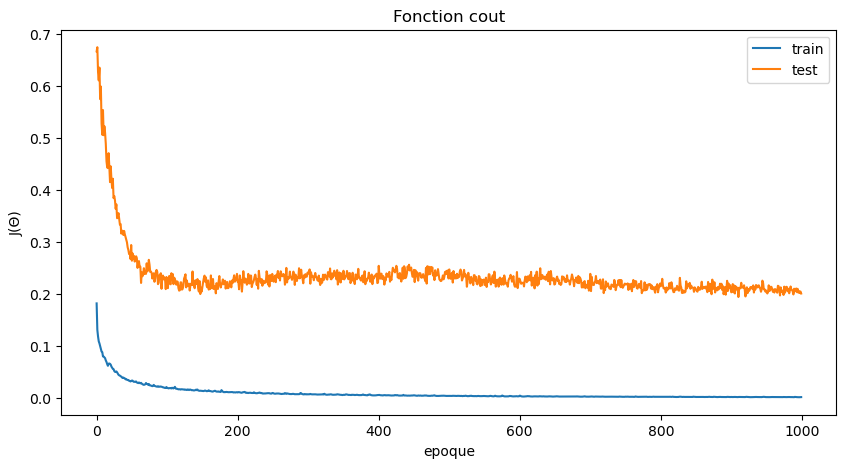

In [28]:
#Evolution de la fonction cout
plt.figure(figsize=(10,5))
plt.title("Fonction cout")
plt.plot(train_loss, label=f"train")
plt.plot(eval_loss, label=f"test")
plt.xlabel("epoque")
plt.ylabel('J(Θ)')
plt.legend()
plt.show()  

In [29]:
class PredBatchSampler(Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        num_samples = len(self.data_source)
        begin_i = [i for i in range(0, num_samples - self.batch_size, self.batch_size)]
        indices = torch.arange(num_samples)
        for i in begin_i:
            yield indices[i:i+self.batch_size]
        yield indices[num_samples - num_samples%self.batch_size:]

    def __len__(self):
        return len(self.data_source) // self.batch_size

def test_prediction_TSViT(model, dataloader, ):    
    test_pred = np.empty((0,  next(iter(dataloader)).shape[-3], next(iter(dataloader)).shape[-2]))
    batch = 0
    model.to(device)
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch = batch.to(device)
            m_pred = model(batch).cpu().detach().numpy()
            test_pred = np.concatenate((test_pred, m_pred[:,0]), axis=0)

    model.to("cpu")
    return test_pred

In [30]:

#t_test = radar_grouped.hour[t_split].values
t_test = radar_xarray.time[-800].values

samples_test = radar_xarray.sel(time=slice(t_test, None)).copy()
channel_t = np.zeros(samples_test["radar"].shape)
channel_t[:,0 , 0] = [datetime64_to_number(i) for i in samples_test["time"].values]
samples_test = samples_test.assign(time_c=(["time", "lat", "lon"], channel_t))
samples_test = samples_test.rolling(time=6*3, center=True).construct("min")
samples_test = samples_test.assign_coords(time=(samples_test.time - pd.Timedelta(minutes=30)) )
samples_test = samples_test.dropna(dim="time")
samples_test = samples_test.transpose("time", "min", "lat", "lon")

input_values = torch.tensor(samples_test["radar"].values, dtype=torch.float)
input_channel = torch.tensor(samples_test["time_c"].values, dtype=torch.float)
input_values = input_values.unsqueeze(-1)
input_channel = input_channel.unsqueeze(-1)
input_tensor = torch.cat((input_values, input_channel ), dim=-1) 

batch_pred = 8
pred_dataloader = DataLoader(input_tensor, 
    batch_sampler=PredBatchSampler(TensorDataset(input_tensor), batch_pred),
)
pred = test_prediction_TSViT(net, pred_dataloader)

In [31]:
t_pred_begin = samples_test["time"].values[0]
t_pred_end = samples_test["time"].values[-1]

result_3D = xr.DataArray(pred, 
                  coords=[samples_test["time"].values, samples.lat.values, samples.lon.values], 
                  dims=['time', 'lat', 'lon'],
                  name="radar")


In [32]:
plot_res3D = result_3D.hvplot.image(x="lon", y="lat", c="radar", width=400, height=400, colorbar=True) 
plot_radar3D = radar_xarray.sel(time=slice(t_pred_begin, t_pred_end)).hvplot.image(x="lon", y="lat", c="radar", width=400, height=400, colorbar=True)


plot_res3D+ plot_radar3D

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Image   [lon,lat]   (radar)
   .DynamicMap.II :DynamicMap   [time]
      :Image   [lon,lat]   (radar)

In [33]:
# Selction des heures
datetime_range = np.arange(t_pred_begin, t_pred_end, np.timedelta64(10, 'm'))
minutes = datetime_range.astype('datetime64[m]').astype(int) % 60
indices = np.where(minutes == 0)[0]

y_point_pred = pred[:, gauge_coords[0], gauge_coords[1]]
 

Xarray_result=xr.Dataset(
    {
        "prediction": (["time", "location"], y_point_pred),
        "radar": (["time", "location"], radar_points["radar"].sel(time=slice(t_pred_begin, t_pred_end)).values),
        "jauge": (["hour", "location"], rain[t_pred_begin: t_pred_end])
    },
    coords= {
        "time": radar_xarray["time"].sel(time=slice(t_pred_begin, t_pred_end)).values,
        "location": rain.columns.values,
        "hour": datetime_range[indices]
    })

In [34]:
#t_from = t_test[0]
#t_to = t_test[200]
loc_slice = slice(Xarray_result.location[0].values, Xarray_result.location[20].values)
plt1 = Xarray_result.sel(location=loc_slice
                        ).hvplot.line(x="time", y=["prediction", "radar"], groupby=["location"],
                                      alpha=[0.8, 0.4], line_dash=["solid", "dotted"],
                                      width=800, height=400)
plt2 = Xarray_result.sel(location=loc_slice
                        ).hvplot.line(x="hour", y=["jauge"], groupby=["location"],
                                      alpha=[1], line_dash=["dashed"], label="jauge",
                                      width=800, height=400)
plt1 * plt2

:DynamicMap   [location]
   :Overlay
      .NdOverlay.I :NdOverlay   [Variable]
         :Curve   [time]   (value)
      .Curve.Jauge :Curve   [hour]   (jauge)

In [35]:
Xarray_result_mean = Xarray_result.resample(time="h").mean()
Xarray_result_mean = Xarray_result_mean.isel(time=slice(1, -1))
Xarray_result_mean = Xarray_result_mean.sel(hour=Xarray_result_mean.time )

In [36]:
#0.068 pour lr 1e-5, dim 64
#0.058 pour lr 1e-5, dim 128
mean_squared_error(Xarray_result_mean["prediction"].values, Xarray_result_mean["jauge"].values)

0.0689064537739034

In [37]:
mean_squared_error(Xarray_result_mean["radar"].values, Xarray_result_mean["jauge"].values)

0.05934518861800766